# Step 1: Load Required Libraries

In [128]:
import numpy as np # Handles arrays
import os # Works with files & folders 
import zipfile # EXTRACT ZIP FILE 
import cv2 # Reads, processes, and resizes images.
import matplotlib.pyplot as plt
import seaborn as sns # Makes heatmaps (confusion matrix visualization)
from collections import Counter # Counts occurrences of classes (e.g., melanoma vs. non-melanoma).
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Augments images (rotation, flipping, etc.) to improve training.
from tensorflow.keras.models import Sequential, load_model # Builds and loads deep learning models.
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # Layers for CNN model.
from tensorflow.keras.applications import InceptionV3 # Pre-trained deep learning model (transfer learning).
from tensorflow.keras.optimizers import Adam # Optimizer that improves model learning.



In [129]:
!pip install opencv-python



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Step 3: Verify Extraction & List Images

In [130]:


# Define correct paths as strings
train_folder = "ISIC_2019_Training_Extracted/ISIC_2019_Training_Input"
test_folder = "ISIC_2019_Test_Extracted/ISIC_2019_Test_Input"

# Check if folders exist before listing images
if os.path.exists(train_folder):
    train_images = os.listdir(train_folder)
    print(f"✔ Total training images: {len(train_images)}")
else:
    print(f"❌ Training folder not found: {train_folder}")

if os.path.exists(test_folder):
    test_images = os.listdir(test_folder)
    print(f"✔ Total test images: {len(test_images)}")
else:
    print(f"❌ Test folder not found: {test_folder}")


✔ Total training images: 25333
✔ Total test images: 8241


# Step 3: Load CSV Files & Display Dataset Information

In [131]:
import pandas as pd  # Import pandas

# Load the metadata CSV file
csv_path = "ISIC_2019_Training_GroundTruth (1).csv"
df = pd.read_csv(csv_path)

# Display first 5 rows
print("First 5 rows of CSV file:")
print(df.head())

# Check number of unique classes
print("\nUnique classes in dataset:")
print(df.columns[1:])  # Labels start from column 1

# Show column names
print("\nColumn names in the dataset:")
print(df.columns)

# Check total number of images
print(f"\nTotal images available: {df.shape[0]}")


First 5 rows of CSV file:
          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0

Unique classes in dataset:
Index(['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], dtype='object')

Column names in the dataset:
Index(['image', 'MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], dtype='object')

Total images available: 25331


# Step 4: Visualize Sample Images

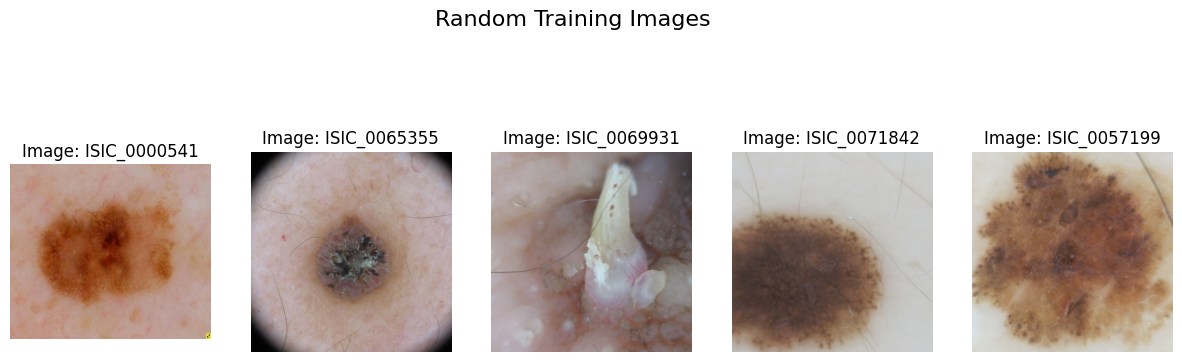

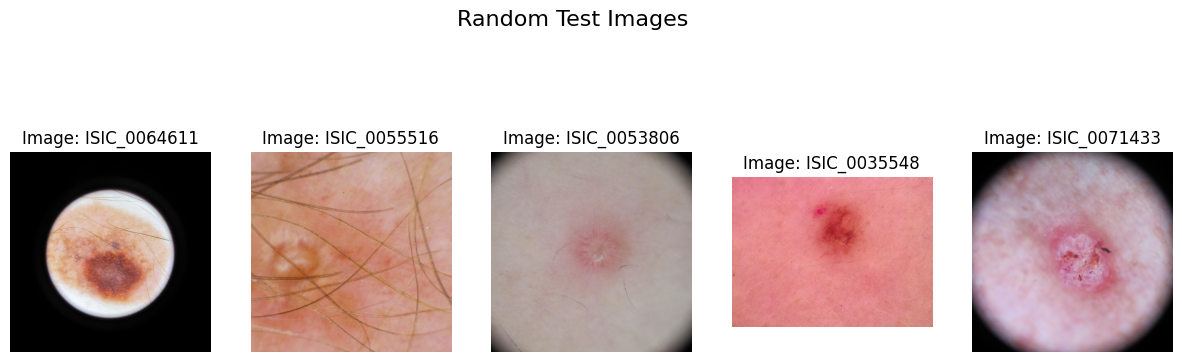

In [132]:


def show_random_images(dataframe, img_folder, num_images=5, title="Random Images"):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    for i in range(num_images):
        img_name = np.random.choice(dataframe['image'])  # Randomly select an image
        img_path = os.path.join(img_folder, img_name + ".jpg")  # Construct full path

        img = cv2.imread(img_path)  # Read image
        
        if img is None:  # ✅ Check if image was loaded successfully
            print(f"Error: Could not read image at {img_path}")
            continue  # Skip to next image
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        axes[i].imshow(img)  # Display image
        axes[i].axis("off")  # Hide axes
        axes[i].set_title(f"Image: {img_name}")  # Set title

    plt.show()  # Show images

# Paths for training & test images
train_folder = "ISIC_2019_Training_Extracted/ISIC_2019_Training_Input"
test_folder = "ISIC_2019_Test_Extracted/ISIC_2019_Test_Input"

# Visualize Training Images
show_random_images(df, train_folder, num_images=5, title="Random Training Images")

# Visualize Test Images (Assuming test images do not have labels)
test_images = [f.split('.')[0] for f in os.listdir(test_folder) if f.endswith('.jpg')]
test_df = pd.DataFrame({'image': test_images})

# Visualize Test Images
show_random_images(test_df, test_folder, num_images=5, title="Random Test Images")


# Step 5: Data Preprocessing & Augmentation

In [133]:
# Define image size
IMG_SIZE = (224, 224) #  Target image size for the model ( for deep learning models their will be fixed size)

# Create a function to preprocess images
def load_and_preprocess_image(img_path): # loads an image from a file and applies preprocessing to prepare it for model prediction.
    img = cv2.imread(img_path) # loads an image in BGR format (default for OpenCV)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize Pixel Values (Scale Between 0 and 1) Normalizing between 0 and 1 improves model training by stabilizing learning.
    return img


# TRY

In [134]:

import pandas as pd # for handling structured data (CSV files, tables, datasets, etc.).
import tensorflow as tf # TensorFlow is an open-source deep learning framework used for building, training, and deploying machine learning models.
from sklearn.model_selection import train_test_split


In [135]:
import os
import pandas as pd

# ✅ 1. Set the correct image folder path
train_extract_path = "ISIC_2019_Training_Extracted/ISIC_2019_Training_Input"

# ✅ 2. Check a few file names from folder
image_files = [f for f in os.listdir(train_extract_path) if f.endswith('.jpg')]
print(f"Total image files found in folder: {len(image_files)}")
print("Sample filenames from folder:", image_files[:5])

# ✅ 3. Check your DataFrame
print("\nFirst few image names in your DataFrame BEFORE adding .jpg:")
print(df['image'].head())

# ✅ 4. Add .jpg extension
df["image"] = df["image"].astype(str) + ".jpg"

print("\nAfter adding .jpg:")
print(df["image"].head())

# ✅ 5. Check which image names are NOT in the folder
existing_images = set(image_files)
df["exists"] = df["image"].apply(lambda x: x in existing_images)

# ✅ 6. Show how many exist and how many don’t
print("\nImage existence check:")
print(df["exists"].value_counts())

# ✅ 7. Filter DataFrame to keep only existing images
df = df[df["exists"] == True].drop(columns=["exists"])
print(f"\n✅ Updated DataFrame size: {df.shape}")


Total image files found in folder: 25331
Sample filenames from folder: ['ISIC_0000000.jpg', 'ISIC_0000001.jpg', 'ISIC_0000002.jpg', 'ISIC_0000003.jpg', 'ISIC_0000004.jpg']

First few image names in your DataFrame BEFORE adding .jpg:
0    ISIC_0000000
1    ISIC_0000001
2    ISIC_0000002
3    ISIC_0000003
4    ISIC_0000004
Name: image, dtype: object

After adding .jpg:
0    ISIC_0000000.jpg
1    ISIC_0000001.jpg
2    ISIC_0000002.jpg
3    ISIC_0000003.jpg
4    ISIC_0000004.jpg
Name: image, dtype: object

Image existence check:
exists
True    25331
Name: count, dtype: int64

✅ Updated DataFrame size: (25331, 10)


# Apply Data Augmentation

In [136]:

import shutil # used for copying, moving, renaming, and deleting files & directories.
from tensorflow.keras.utils import to_categorical # Convert Labels to One-Hot Encoding
from tqdm import tqdm # makes loops visually trackable by displaying a progress bar. Useful for iterating over large datasets efficiently.




In [137]:
# Define paths for training images, test images, and labels
train_img_dir = "ISIC_2019_Training_Extracted/ISIC_2019_Training_Input"
test_img_dir = "ISIC_2019_Test_Extracted/ISIC_2019_Test_Input"
train_csv_path = "ISIC_2019_Training_GroundTruth (1).csv"

# Ensure directories exist
assert os.path.exists(train_img_dir), f"Training image directory not found: {train_img_dir}"
assert os.path.exists(test_img_dir), f"Test image directory not found: {test_img_dir}"
assert os.path.exists(train_csv_path), f"Training CSV file not found: {train_csv_path}"


In [138]:




# Check for missing values
print("Missing Values in Labels:")
print(df.isnull().sum())

# Get all class columns (disease types)
label_columns = df.columns[1:]  # Skipping the first column (image ID)

# Ensure only one label per image
df['num_labels'] = df[label_columns].sum(axis=1)
assert df['num_labels'].max() == 1, "Some images have multiple labels!"

# Convert multi-label to single-label (find the column with 1)
df['label'] = df[label_columns].idxmax(axis=1)

# Drop unnecessary columns
df = df[['image', 'label']]


Missing Values in Labels:
image    0
MEL      0
NV       0
BCC      0
AK       0
BKL      0
DF       0
VASC     0
SCC      0
UNK      0
dtype: int64


In [139]:

# Load the CSV file
df = pd.read_csv("ISIC_2019_Training_GroundTruth (1).csv")

# Print initial preview
print("Original Data Labels Preview:")
print(df.head())

# Ensure column names are correct
print("\nColumn Names in CSV:")
print(df.columns.tolist())

# Get all class columns (excluding 'image')
label_columns = df.columns[1:]  # Exclude 'image' column

# Debug: Check if label_columns contains class names
print("\nClass Columns Detected:", label_columns)

# Convert one-hot encoding to single-label classification
df['label'] = df[label_columns].idxmax(axis=1)  # Get the class with max value

# Drop the original one-hot encoded columns
df = df[['image', 'label']]

# Print final output
print("\nUpdated Data Labels:")
print(df.head())


Original Data Labels Preview:
          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0

Column Names in CSV:
['image', 'MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']

Class Columns Detected: Index(['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], dtype='object')

Updated Data Labels:
          image label
0  ISIC_0000000    NV
1  ISIC_0000001    NV
2  ISIC_0000002   MEL
3  ISIC_0000003    NV
4  ISIC_0000004   MEL


Class Distribution:
label
NV      12875
MEL      4522
BCC      3323
BKL      2624
AK        867
SCC       628
VASC      253
DF        239
Name: count, dtype: int64


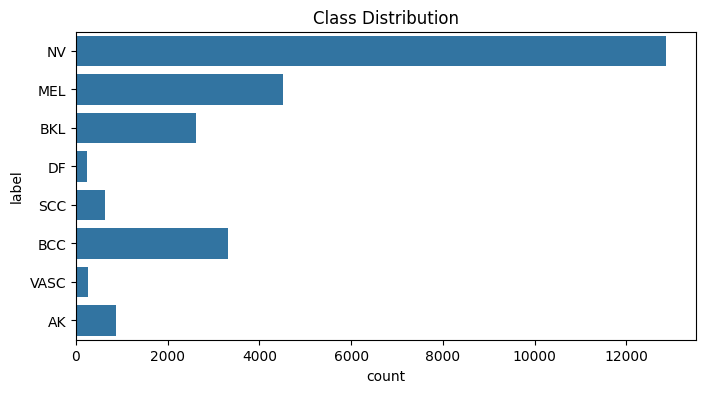

In [140]:
# Convert label column to string (required for ImageDataGenerator with class_mode='binary')
df['label'] = df['label'].astype(str)

# Display class distribution
print("Class Distribution:")
print(df['label'].value_counts())

# Plot class distribution
plt.figure(figsize=(8, 4))
sns.countplot(y=df['label'])
plt.title("Class Distribution")
plt.show()


In [141]:
# Split data into training and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Reset index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print("Training Samples:", len(train_df))
print("Validation Samples:", len(val_df))


Training Samples: 20264
Validation Samples: 5067


In [142]:
print(train_df["label"].unique())  # Should output ['0', '1']
print(val_df["label"].unique())    # Should output ['0', '1']


['NV' 'MEL' 'BCC' 'SCC' 'AK' 'BKL' 'DF' 'VASC']
['BKL' 'SCC' 'MEL' 'BCC' 'AK' 'NV' 'DF' 'VASC']


In [143]:
train_df['label'] = train_df['label'].astype(str)  # Ensure labels are strings
val_df['label'] = val_df['label'].astype(str)


In [144]:
train_df["image"] = train_df["image"] + ".jpg"
val_df["image"] = val_df["image"] + ".jpg"


In [145]:
import os

train_img_dir = "ISIC_2019_Training_Extracted/ISIC_2019_Training_Input"

# List first 10 images in the directory
print("Files in image directory:", os.listdir(train_img_dir)[:10])


Files in image directory: ['ATTRIBUTION.txt', 'ISIC_0000000.jpg', 'ISIC_0000001.jpg', 'ISIC_0000002.jpg', 'ISIC_0000003.jpg', 'ISIC_0000004.jpg', 'ISIC_0000006.jpg', 'ISIC_0000007.jpg', 'ISIC_0000008.jpg', 'ISIC_0000009.jpg']


In [146]:
print(train_df["image"].head())  # Should contain only filenames (e.g., "ISIC_0000001.jpg")


0    ISIC_0033283.jpg
1    ISIC_0055317.jpg
2    ISIC_0056356.jpg
3    ISIC_0070561.jpg
4    ISIC_0066198.jpg
Name: image, dtype: object


In [147]:


# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

# Define Data Augmentation for training set
train_datagen = ImageDataGenerator(  # This helps improve model generalization and prevent overfitting by generating slightly modified versions of the same image.
    rescale=1./255, # Normalize pixel values (0-255 → 0-1)
    rotation_range=30, # Randomly rotate images up to 30 degrees
    width_shift_range=0.2, # Shift image horizontally by up to 20% of width
    height_shift_range=0.2, # Shift image horizontally by up to 20% of height
    shear_range=0.2, # Apply shear transformation  # stretching it diagonally look object slantely
    zoom_range=0.2, #  Randomly zoom in on images
    horizontal_flip=True, # Flip images horizontally
    fill_mode="nearest" # Fill missing pixels after transformation
)

# No augmentation for validation set, only rescaling
val_datagen = ImageDataGenerator(rescale=1./255) # Only normalization


In [148]:
# Path where images are stored
train_img_dir = "ISIC_2019_Training_Extracted/ISIC_2019_Training_Input"

# Flow images from directory for training
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, # DataFrame containing image names & labels
    directory=train_img_dir, # Folder where images are stored
    x_col="image",  # Image filenames
    y_col="label",  # Binary class labels
    target_size=IMG_SIZE, # Resize images to required size (224x224)
    batch_size=BATCH_SIZE,  # Number of images per batch
    class_mode="categorical",  # Binary classification # Multi-class classification
    shuffle=True # Randomly shuffle images for training
)

# Flow images from directory for validation
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df, # Validation DataFrame
    directory=train_img_dir, # Folder containing images
    x_col="image",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False # No shuffling for validation (ensures consistency)
)

# Verify class indices
print("Class indices:", train_generator.class_indices)


Found 20264 validated image filenames belonging to 8 classes.
Found 5067 validated image filenames belonging to 8 classes.
Class indices: {'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}


# MODEL TRY 

In [149]:

from tensorflow.keras.callbacks import EarlyStopping


In [150]:
from tensorflow.keras.layers import BatchNormalization
def build_cnn_model(input_shape=(224, 224, 3), num_classes=8): # The model expects 224×224 images with 3 color channels (RGB). num_classes=8 → The dataset has 8 different skin disease categories (e.g., MEL, NV, BCC, etc.).
    model = Sequential([ # Creates a model where layers are added one after another.
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape), # Uses 32 filters (small patterns to detect edges, textures). Each filter is 3×3 in size (small region scanning). ReLU activation → Removes negative values (improves learning).
        MaxPooling2D(2,2), # Reduces image size by half (takes the most important features).
        BatchNormalization(), # Normalizes activations (faster training, avoids overfitting).
        
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(), #  Stabilizes training.
        
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2), # Further reduces dimensions.
        BatchNormalization(), # keeps values normalized for stability.
        
        Flatten(), # Converts 2D feature maps into 1D vector for classification.
        Dense(128, activation='relu'), # Fully connected layer to learn patterns
        Dropout(0.5), # Drops 50% of neurons to prevent overfitting.
        Dense(num_classes, activation='softmax')  # inal layer outputs 8 values (1 per class). Softmax activation assigns probabilities to each class (total = 100%).

    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001),  # Adaptive learning optimizer (efficient gradient updates). Small learning rate (0.0001) ensures smooth learning.
                  loss='categorical_crossentropy', # Used because the dataset has multiple classes (8 classes). Computes error between predicted probabilities & actual labels.
                  metrics=['accuracy']) # Evaluates model performance based on accuracy.
    return model

# Create CNN model
cnn_model = build_cnn_model()
cnn_model.summary()


C:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_291 (Conv2D)                  │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_291              │ (None, 111, 111, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_292 (Conv2D)                  │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_292              │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_293 (Conv2D)                  │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_293              │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,888 (42.61 MB)

 Trainable params: 11,170,440 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [151]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

def build_inception_model(input_shape=(224, 224, 3), num_classes=8): # The model expects 224×224 images with 3 color channels (RGB). num_classes=8 → The dataset has 8 different skin disease categories (e.g., MEL, NV, BCC, etc.).
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape) # Loads InceptionV3 with pre-trained weights from ImageNet.
# include_top=False → Removes the fully connected layers of InceptionV3 (since we will add our own classifier).
# input_shape=input_shape ensures the model takes in 224×224 images.

    
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base model layers # Freezes all layers in InceptionV3 to prevent modification during training.
# This helps retain the pre-trained features from ImageNet while we train only the new classifier.
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)  # Multi-class classification # GlobalAveragePooling2D(): Replaces the removed InceptionV3 fully connected layers. It reduces feature maps into a single vector per image.
 # Dense(128, activation='relu'): Adds a fully connected (FC) layer with 128 neurons and ReLU activation to learn new patterns.
# Dropout(0.5): Randomly drops 50% of neurons to prevent overfitting.
# Dense(num_classes, activation='softmax'): Final layer for multi-class classification (8 classes)
    
    model = Model(inputs=base_model.input, outputs=output)
    
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
# Adam(learning_rate=0.0001) → Optimizes the model using the Adam optimizer (efficient and widely used).
# categorical_crossentropy → Loss function used for multi-class classification.
# metrics=['accuracy'] → Model evaluates performance based on accuracy.

    return model

# Create InceptionV3 model
inception_model = build_inception_model()
inception_model.summary()


Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_294 (Conv2D)           │ (None, 111, 111, 32)      │             864 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_294       │ (None, 111, 111, 32)      │              96 │ conv2d_294[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_282 (Activation)   │ (None, 111, 111, 32)      │               0 │ batch_normalization_294[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_295 (Conv2D)           │ (None, 109, 109, 32)      │           9,216 │ activation_282[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_295       │ (None, 109, 109, 32)      │              96 │ conv2d_295[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_283 (Activation)   │ (None, 109, 109, 32)      │               0 │ batch_normalization_295[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_296 (Conv2D)           │ (None, 109, 109, 64)      │          18,432 │ activation_283[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_296       │ (None, 109, 109, 64)      │             192 │ conv2d_296[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_284 (Activation)   │ (None, 109, 109, 64)      │               0 │ batch_normalization_296[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_24              │ (None, 54, 54, 64)        │               0 │ activation_284[0][0]       │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_297 (Conv2D)           │ (None, 54, 54, 80)        │           5,120 │ max_pooling2d_24[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_297       │ (None, 54, 54, 80)        │             240 │ conv2d_297[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_285 (Activation)   │ (None, 54, 54, 80)        │               0 │ batch_normalization_297[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_298 (Conv2D)           │ (None, 52, 52, 192)       │         138,24

 Total params: 22,066,088 (84.18 MB)

 Trainable params: 263,304 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [77]:
# Define early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train CNN
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)

# Train InceptionV3
history_inception = inception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)


C:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
317/317 ━━━━━━━━━━━━━━━━━━━━ 1128s 4s/step - accuracy: 0.4259 - loss: 2.8326 - val_accuracy: 0.5092 - val_loss: 1.7144
Epoch 2/7
317/317 ━━━━━━━━━━━━━━━━━━━━ 1110s 4s/step - accuracy: 0.4791 - loss: 1.6763 - val_accuracy: 0.5540 - val_loss: 1.2613
Epoch 3/7
317/317 ━━━━━━━━━━━━━━━━━━━━ 1152s 4s/step - accuracy: 0.5105 - loss: 1.5197 - val_accuracy: 0.5421 - val_loss: 1.3487
Epoch 4/7
317/317 ━━━━━━━━━━━━━━━━━━━━ 1165s 4s/step - accuracy: 0.5103 - loss: 1.4563 - val_accuracy: 0.5540 - val_loss: 1.4593
Epoch 5/7
317/317 ━━━━━━━━━━━━━━━━━━━━ 1171s 4s/step - accuracy: 0.5270 - loss: 1.4029 - val_accuracy: 0.5556 - val_loss: 1.3253
Epoch 6/7
317/317 ━━━━━━━━━━━━━━━━━━━━ 1176s 4s/step - accuracy: 0.5287 - loss: 1.3648 - val_accuracy: 0.5563 - val_loss: 1.2332
Epoch 7/7
317/317 ━━━━━━━━━━━━━━━━━━━━ 1192s 4s/step - accuracy: 0.5399 - loss: 1.3159 - val_accuracy: 0.5642 - val_loss: 1.1874
Epoch 1/7
317/317 ━━━━━━━━━━━━━━━━━━━━ 1383s 4s/step - accuracy: 0.4594 - loss: 1.6200 - val_accu

In [152]:
from tensorflow.keras.models import load_model
cnn_model = load_model("cnn_model (1).h5")
inception_model = load_model("inception_model (1).h5")


In [153]:
# Create a label map for your classes (adjust as needed)
label_map = {'MEL': 0, 'NV': 1, 'BCC': 2, 'AK': 3, 'BKL': 4, 'DF': 5, 'VASC': 6, 'SCC': 7}

# Map the labels in train_df
train_df['label'] = train_df['label'].map(label_map)

# Check the mapping
print(train_df['label'].value_counts())


label
1    10300
0     3618
2     2658
4     2099
3      694
7      502
6      202
5      191
Name: count, dtype: int64


In [154]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure generator is reset
val_generator.reset()

# Get true labels
y_true = val_generator.classes

# Predict using CNN
val_generator.reset()
y_pred_cnn = np.argmax(cnn_model.predict(val_generator, steps=len(val_generator)), axis=1)

# Predict using InceptionV3
val_generator.reset()
y_pred_incep = np.argmax(inception_model.predict(val_generator, steps=len(val_generator)), axis=1)



C:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step


📊 Model Evaluation (in %):
      Metric  CNN (%)  InceptionV3 (%)
0   Accuracy    83.61            88.67
1  Precision    75.01            87.96
2   F1-Score    70.98            87.95


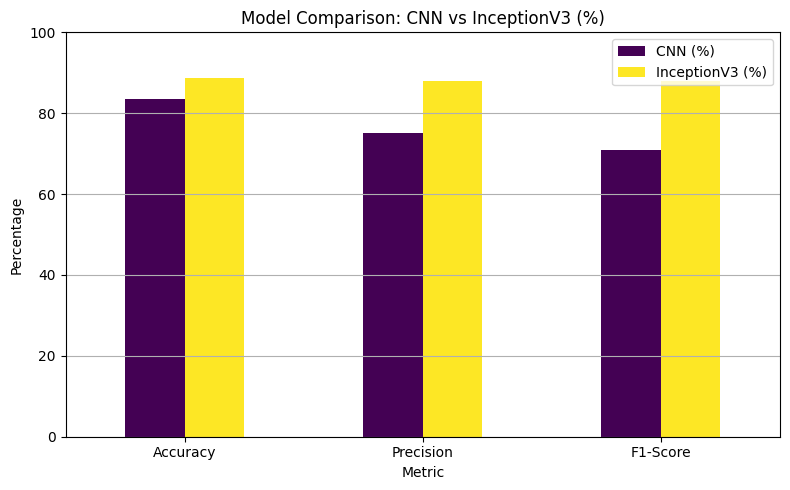


✅ Best Model: InceptionV3 (Average: 88.19%)


In [125]:
# Metric function
def get_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0) * 100
    return round(acc, 2), round(prec, 2), round(f1, 2)

# Compute metrics
cnn_metrics = get_metrics(y_true, y_pred_cnn)
inception_metrics = get_metrics(y_true, y_pred_incep)

# Display table
df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'F1-Score'],
    'CNN (%)': cnn_metrics,
    'InceptionV3 (%)': inception_metrics
})

print("📊 Model Evaluation (in %):")
print(df)

# Bar graph
df.set_index('Metric').plot(kind='bar', colormap='viridis', figsize=(8, 5))
plt.title('Model Comparison: CNN vs InceptionV3 (%)')
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Best model based on average
avg_cnn = np.mean(cnn_metrics)
avg_incep = np.mean(inception_metrics)

if avg_cnn > avg_incep:
    print(f"\n✅ Best Model: CNN (Average: {avg_cnn:.2f}%)")
else:
    print(f"\n✅ Best Model: InceptionV3 (Average: {avg_incep:.2f}%)")


# Preprocess Test Image

In [31]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to preprocess a test image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize
    img_array = image.img_to_array(img) / 255.0  # Normalize (0-1)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array


# Predict Using CNN & InceptionV3

In [32]:
# Path to the test image (update with actual test image)
test_img_path = "ISIC_2019_Test_Extracted/ISIC_2019_Test_Input/ISIC_0034332.jpg"  

# Preprocess the image
img_array = preprocess_image(test_img_path)

# Predict using CNN & InceptionV3
cnn_pred = cnn_model.predict(img_array)  
inception_pred = inception_model.predict(img_array)

# Print raw probabilities for debugging
print("\n🔹 Raw Prediction Probabilities:")
print(f"CNN Prediction Probabilities: {cnn_pred}")
print(f"InceptionV3 Prediction Probabilities: {inception_pred}")

# Convert probabilities to class labels
cnn_class = np.argmax(cnn_pred, axis=1)[0]  
inception_class = np.argmax(inception_pred, axis=1)[0]  

print("\n🔹 Model Predictions:")
print(f"CNN Model Prediction (Class Index): {cnn_class}")
print(f"InceptionV3 Model Prediction (Class Index): {inception_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

🔹 Raw Prediction Probabilities:
CNN Prediction Probabilities: [[1.0825823e-03 6.2582147e-01 1.4140760e-02 3.2524395e-04 5.7990267e-04
  3.5461587e-01 1.0061577e-03 2.4279957e-03]]
InceptionV3 Prediction Probabilities: [[0.05231854 0.17789435 0.11159055 0.06041492 0.1005499  0.40278146
  0.0618153  0.03263494]]

🔹 Model Predictions:
CNN Model Prediction (Class Index): 1
InceptionV3 Model Prediction (Class Index): 5


In [127]:
# Check if the final prediction is MEL (Melanoma)
if final_label == "MEL":
    print("\n⚠️ Melanoma Detected! ⚠️")
else:
    print("\n✅ No Melanoma Detected.")



✅ No Melanoma Detected.
